In [ ]:
import r3.adapters as adapters
import r3.schema as schema


X_columns = [
    schema.IVTReactionSchema.pH.value,
    # schema.IVTReactionSchema.TIME_min.value,
]
y_columns = [schema.IVTReactionSchema.RNA_g_L.value]
experimental_conditions, response = adapters.DataPipelineAdapter(
    "kate_ph_repeat", verbose=False
).get(
    X_columns=X_columns,
    y_columns=y_columns,
    paths_to_merge=[
        ["charlie_ph", "Sheet1"],
        ["ricardo_ph", "CSP HEPES"],
        ["ricardo_ph", "eGFP HEPES"],
        ["ricardo_ph", "eGFP TRIS"],
    ],
)
experimental_data = experimental_conditions
experimental_data[y_columns[0]] = response[y_columns[0]]
experimental_data

,pH,RNA [g/L]
0,6.57,0.000000
1,6.52,1.322399
2,6.49,2.844903
3,6.41,5.138938
4,6.37,7.869962
5,6.37,9.969641
6,6.29,11.647534
7,6.25,12.824160
8,6.20,13.605147
9,6.17,14.279864


<Axes: xlabel='pH', ylabel='RNA [g/L]'>

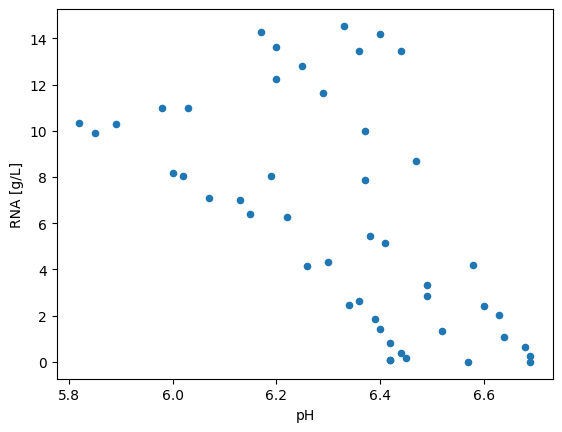

In [6]:
# visualise the data separate RNA and pH into different Axis
experimental_data.plot(
    x=schema.IVTReactionSchema.pH.value,
    y=schema.IVTReactionSchema.RNA_g_L.value,
    kind="scatter",
)

In [7]:
# fit a gaussian process model and an xgboost model
import xgboost
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.base import BaseEstimator
import numpy as np
import json

# Train test split
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    experimental_conditions[X_columns].values,
    response[y_columns[0]].values,
    test_size=0.2,
    random_state=42,
)
gp = GaussianProcessRegressor(
    kernel=C(1.0, constant_value_bounds="fixed")
    * RBF(length_scale=1.0, length_scale_bounds="fixed"),
    n_restarts_optimizer=10,
)
gp.fit(X_train, y_train)
xgb_model = xgboost.XGBRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
)
xgb_model.fit(X_train, y_train)


# Evaluate the models using R squared, MAE and RMSE for train and test sets
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


def evaluate_model(model: BaseEstimator, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    return {
        "r2": {"train": r2_train, "test": r2_test},
        "mae": {"train": mae_train, "test": mae_test},
        "rmse": {"train": rmse_train, "test": rmse_test},
    }


gp_metrics = evaluate_model(gp, X_train, y_train, X_test, y_test)
xgb_metrics = evaluate_model(xgb_model, X_train, y_train, X_test, y_test)
print("Gaussian Process Metrics:", json.dumps(gp_metrics, indent=4))
print("XGBoost Metrics:", json.dumps(xgb_metrics, indent=4))

Gaussian Process Metrics: {
    "r2": {
        "train": 0.3954440635869154,
        "test": 0.38878443756803005
    },
    "mae": {
        "train": 3.015500781115469,
        "test": 2.4441993156186284
    },
    "rmse": {
        "train": 3.7623759983831717,
        "test": 3.1177825723319885
    }
}
XGBoost Metrics: {
    "r2": {
        "train": 0.657857486969682,
        "test": 0.3591781109061669
    },
    "mae": {
        "train": 1.9697501270643798,
        "test": 2.6026067100860986
    },
    "rmse": {
        "train": 2.830397752153437,
        "test": 3.1923999278772035
    }
}


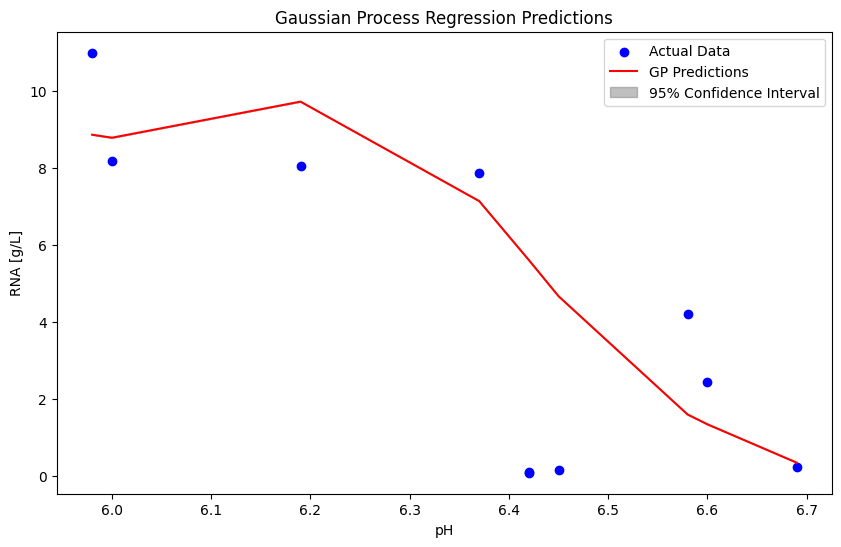

In [8]:
# plot the gaussian process model predictions
import matplotlib.pyplot as plt

y_test_pred, std = gp.predict(X_test, return_std=True)

# Sort by pH (X_test[:, 0]) for smoother confidence interval plotting
sorted_indices = np.argsort(X_test[:, 0])
X_test_sorted = X_test[sorted_indices]
y_test_sorted = y_test[sorted_indices]
y_test_pred_sorted = y_test_pred[sorted_indices]
std_sorted = std[sorted_indices]

plt.figure(figsize=(10, 6))
plt.scatter(X_test_sorted[:, 0], y_test_sorted, color="blue", label="Actual Data")
plt.plot(X_test_sorted[:, 0], y_test_pred_sorted, color="red", label="GP Predictions")
plt.fill_between(
    X_test_sorted[:, 0],
    y_test_pred_sorted - 1.96 * std_sorted,
    y_test_pred_sorted + 1.96 * std_sorted,
    color="gray",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel(schema.IVTReactionSchema.pH.value)
plt.ylabel(schema.IVTReactionSchema.RNA_g_L.value)
plt.title("Gaussian Process Regression Predictions")
plt.legend()